In [3]:
import os
import cv2
import yaml
import json
import PyPDF2
import easyocr
import logging
import camelot
import itertools
import pytesseract
import numpy as np
import pandas as pd
from wand.image import Image
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from predict import predict, visualize
from pdf2image import convert_from_path

Using TensorFlow backend.


In [153]:
class TableExtraction:
    def __init__(self):
        pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
        os.environ['PATH'] += r';C:\Program Files\Tesseract-OCR'
        logger = logging.getLogger('easyocr')
        logger.setLevel(logging.ERROR)

        self.file_path = ''
        # pytesseract config
        self.custom_config = r'--oem 1 --psm 1 -l rus'

    def is_image_based_pdf(self, file_path):
        file_extension = os.path.splitext(self.file_path)[1]
        if file_extension == '.pdf':
            try:
                pdf_file = open(file_path, 'rb')
                pdf_reader = PyPDF2.PdfReader(pdf_file)

                # Read the first page of the PDF
                first_page = pdf_reader.pages[0]

                # Check if the page contains any text
                return len(first_page.extract_text().strip()) == 0

            except Exception as e:
                print(f"Error: {e}")
                return False
        else:
            raise ValueError('Unsupported file format')

    def process_tables(self):
        tables = camelot.read_pdf(
            self.file_path, strip_text='\n', pages='all', flavor='stream', encoding='utf-8')
        # tables = camelot.read_pdf(self.file_path, strip_text='\n', line_scale=40, pages='all', copy_text=['h'])

        if not os.path.exists("results"):
            os.makedirs("results")

        def contains_cid(table):
            for row in table.df.itertuples(index=False):
                for cell in row:
                    if "(cid:" in str(cell):
                        return True
            return False

        for num, table in enumerate(tables):
            if contains_cid(table):
                print(f"Font or encoding error in table")

                file_name = os.path.basename(self.file_path)
                output_file = f"results/{os.path.splitext(file_name)[0]}_table_{num}.csv"
                table.to_csv(output_file, index=False)
            else:
                file_name = os.path.basename(self.file_path)
                output_file = f"results/{os.path.splitext(file_name)[0]}_table_{num}.csv"
                table.to_csv(output_file, index=False)
                # tables.export(output_file, f='csv', compress=True, encoding='utf-8')

    def file_to_array(self, dpi=300):
        poppler_path = os.path.join(os.environ.get(
            'PROGRAMFILES', 'C:\\Program Files'), 'poppler-23.07.0', 'Library', 'bin')
        images = convert_from_path(
            self.file_path, dpi=dpi, poppler_path=poppler_path)
        return [np.array(image) for image in images]

    def grayzation(self, images_array):
        gray_images = []
        for image in images_array:
            gray_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        return gray_images

    def show_gray_images(self):
        for gray_image in self.gray_images:
            plt.imshow(cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    def binarization(self, images_array):
        threshold_images = []
        for gray_image in images_array:
            _, threshold_image = cv2.threshold(
                gray_image, 200, 255, cv2.THRESH_BINARY)
            threshold_images.append(threshold_image)
        return threshold_images

    def show_threshold_images(self):
        for threshold_image in self.threshold_images:
            plt.imshow(cv2.cvtColor(threshold_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    def get_tables(self):
        self.tables_borders = []
        self.tables_bboxes = []
        tables = []

        low_quality_images_arrays = self.file_to_array(dpi=self.low_dpi)
        gray_low_quality_images_arrays = self.grayzation(
            low_quality_images_arrays)

        # self.gray_images = []
        # self.gray_images.append(cv2.cvtColor(cv2.imread('image.jpg'), cv2.COLOR_BGR2GRAY))

        for num, gray_image in enumerate(gray_low_quality_images_arrays):
            # Inverted binarizing transform
            _, threshold_image = cv2.threshold(
                gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

            # Applying a morphological transformation to remove noise and close lines
            kernel = np.ones((10, 10), np.uint8)
            morph_image = cv2.morphologyEx(
                threshold_image, cv2.MORPH_CLOSE, kernel)

            # Finding contours in an image
            contours, hierarchy = cv2.findContours(
                morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            height, width = gray_image.shape
            # Filtering outlines and defining cell bounding boxes
            for contour in contours:
                # Filtering contours by area
                area = cv2.contourArea(contour)
                x, y, w, h = cv2.boundingRect(contour)
                if area > 0.005 * height * width and w > 0.25 * width and h > 0.5 * w:
                    # Adding a bounding box to a list
                    x, y, w, h = cv2.boundingRect(contour)

                    # Crop the table from the sheet
                    croped_gray_image = gray_image[y:y + h, x:x + w]
                    height, width = croped_gray_image.shape
                    _, croped_threshold_image = cv2.threshold(
                        croped_gray_image, 200, 255, cv2.THRESH_BINARY)
                    boxes = pytesseract.image_to_boxes(
                        croped_threshold_image, config=self.custom_config)
                    box_lines = boxes.strip().split('\n')
                    boxes_list = [line.split() for line in box_lines]
                    borders = []
                    epsilon = (height + width) * 0.02

                    # Check if there are lines on the croped image
                    if boxes_list[0] != []:
                        for box in boxes_list:
                            if box[0] == '~' and ((abs(int(box[1]) - int(box[3])) <= epsilon) or (abs(int(box[2]) - int(box[4])) <= epsilon)):
                                x1, y1, x2, y2 = int(box[1]), int(
                                    box[2]), int(box[3]), int(box[4])
                                borders.append([x1, y1, x2, y2])

                    if len(borders) >= 4:
                        x, y, w, h = list(np.array(cv2.boundingRect(
                            contour)) * int(self.high_dpi/self.low_dpi))
                        self.tables_bboxes.append((x, y, x + w, y + h))
                        croped_gray_image = self.gray_images[num][y:y + h, x:x + w]
                        tables.append(croped_gray_image)
                        self.tables_borders.append(
                            list(np.array(borders) * int(self.high_dpi/self.low_dpi)))
        return tables

    def get_tables_with_rcnn(self):
        self.tables_borders = []
        self.tables_bboxes = []
        tables = []

        low_quality_images_arrays = self.file_to_array(dpi=self.low_dpi)

        for num, image in enumerate(low_quality_images_arrays):
            r = predict(image)
            for (bbox, score) in zip(r['rois'], r['scores']):
                if score >= 0.5:
                    y1, x1, y2, x2 = bbox
                    croped_image = image[y1:y2, x1:x2]
                    # copy_image = croped_image.copy()
                    croped_gray_image = cv2.cvtColor(
                        croped_image, cv2.COLOR_BGR2GRAY)
                    height, width = croped_gray_image.shape

                    _, croped_threshold_image = cv2.threshold(
                        croped_gray_image, 200, 255, cv2.THRESH_BINARY)
                    boxes = pytesseract.image_to_boxes(
                        croped_threshold_image, config=self.custom_config)
                    box_lines = boxes.strip().split('\n')
                    boxes_list = [line.split() for line in box_lines]
                    borders = []
                    epsilon = (height + width) * 0.05

                    # Check if there are lines on the croped image
                    if boxes_list[0] != []:
                        for box in boxes_list:
                            # and ((abs(int(box[1]) - int(box[3])) <= epsilon) or (abs(int(box[2]) - int(box[4])) <= epsilon))
                            if box[0] == '~':
                                x1, y1, x2, y2 = int(box[1]), int(
                                    box[2]), int(box[3]), int(box[4])
                                borders.append([x1, y1, x2, y2])
                                # cv2.rectangle(copy_image, (x1, height - y1), (x2, height - y2), (0, 255, 0), 1)

                    y1, x1, y2, x2 = bbox * int(self.high_dpi/self.low_dpi)
                    self.tables_bboxes.append((x1, y1, x2, y2))
                    croped_gray_image = self.gray_images[num][y1:y2, x1:x2]
                    tables.append(croped_gray_image)
                    self.tables_borders.append(
                        list(np.array(borders) * int(self.high_dpi/self.low_dpi)))
            return tables

    def classify_table(self, table_text):
        self.keywords = ["марка", "стали", "временное", "сопротивление",
                         "предел", "текучести", "относительное", "удлинение"]
        self.error_threshold = 0.2
        self.keyword_importance = 0.8

        keywords_found = []

        def partial_compare(word, keyword):
            max_length = max(len(word), len(keyword))
            errors = sum(1 for w, k in zip(word, keyword) if w != k)
            error_ratio = errors / max_length
            return error_ratio <= self.error_threshold

        for keyword in self.keywords:
            found = any(partial_compare(keyword, word.lower())
                        for word in table_text.split())
            if found:
                keywords_found.append(keyword)

        total_keywords = len(self.keywords)
        found_keywords = len(keywords_found)
        confidence = self.keyword_importance * \
            (found_keywords / total_keywords)

        if confidence >= self.error_threshold:
            return True
        else:
            return False

    def filter_tables_by_classification(self):
        filtered_tables = []
        for table in self.tables:
            text = pytesseract.image_to_string(
                table, config=self.custom_config).replace('\n', ' ')
            if self.classify_table(text):
                filtered_tables.append(table)
        return filtered_tables

    def show_table_images(self):
        for table in self.tables:
            plt.imshow(cv2.cvtColor(table, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    def get_lines(self, tables):
        tables_lines = []
        for num, image in enumerate(tables):
            # Get character bounding boxes
            height, width = image.shape
            _, croped_threshold_image = cv2.threshold(
                image, 200, 255, cv2.THRESH_BINARY)
            boxes = pytesseract.image_to_boxes(
                croped_threshold_image, config=self.custom_config)
            box_lines = boxes.strip().split('\n')
            boxes_list = [line.split() for line in box_lines]

            # Tolerance parameters at which we consider that the lines are even and intersect
            epsilon = (height + width) * 0.1

            # Finding all vertical and horizontal lines of a table
            vertical_lines = []
            horizontal_lines = []
            for x1, y1, x2, y2 in self.tables_borders[num]:
                if abs(x1 - x2) < epsilon:  # Vertical lines
                    vertical_lines.append(
                        (int((x1 + x2) / 2), y1, int((x1 + x2) / 2), y2))
                elif abs(y1 - y2) < epsilon:  # Horizontal lines
                    horizontal_lines.append(
                        (x1, int((y1 + y2) / 2), x2, int((y1 + y2) / 2)))

            # Save lines for visualisation
            tables_lines.append((vertical_lines, horizontal_lines))
        return tables_lines

    def get_lines_Hough(self, tables):
        tables_lines = []

        # Extract vertical and horizontal lines in an image using a kernel transform
        for num, image in enumerate(tables):
            height, width = image.shape
            _, threshold_image = cv2.threshold(
                image, 127, 255, cv2.THRESH_BINARY)
            inverted_image = cv2.bitwise_not(threshold_image)

            # Horizontal
            hor = np.array([[1, 1, 1, 1, 1, 1]])
            vertical_lines_eroded_image = cv2.erode(
                inverted_image, hor, iterations=10)
            vertical_lines_eroded_image = cv2.dilate(
                vertical_lines_eroded_image, hor, iterations=10)

            # Vertical
            ver = np.array([[1],
                            [1],
                            [1],
                            [1],
                            [1],
                            [1],
                            [1]])
            horizontal_lines_eroded_image = cv2.erode(
                inverted_image, ver, iterations=10)
            horizontal_lines_eroded_image = cv2.dilate(
                horizontal_lines_eroded_image, ver, iterations=10)

            # Combine
            combined_image = cv2.add(
                vertical_lines_eroded_image, horizontal_lines_eroded_image)

            # Dilate
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
            combined_image_dilated = cv2.dilate(
                combined_image, kernel, iterations=5)

            lines = cv2.HoughLinesP(
                combined_image_dilated, 1, np.pi / 180, 50, None, 50, 10)

            # Recurrent function for checking arrays for emptiness
            def is_not_empty_element(structure):
                if isinstance(structure, list) or isinstance(structure, np.ndarray):
                    return any(is_not_empty_element(item) for item in structure)
                elif isinstance(structure, int) or isinstance(structure, np.intc):
                    return True
                else:
                    return False

            # Finding all vertical and horizontal lines of a table
            vertical_lines = []
            horizontal_lines = []

            if is_not_empty_element(lines):
                borders = np.concatenate(lines, axis=0)

                # Tolerance parameters at which we consider that the lines are even and intersect
                epsilon = (height + width) * 0.01
                for x1, y1, x2, y2 in borders:
                    if abs(x1 - x2) <= epsilon and abs(y1 - y2) > epsilon:  # Vertical lines
                        vertical_lines.append(
                            (int((x1 + x2) / 2), height - y1, int((x1 + x2) / 2), height - y2))
                    elif abs(y1 - y2) <= epsilon and abs(x1 - x2) > epsilon:  # Horizontal lines
                        horizontal_lines.append(
                            (int(x1), height - int((y1 + y2) / 2), int(x2), height - int((y1 + y2) / 2)))

            # Save lines for visualisation
            tables_lines.append((vertical_lines, horizontal_lines))
        return tables_lines

    def show_tables_lines(self):
        for num, table in enumerate(self.tables):
            copy_image = table.copy()
            height, width = copy_image.shape
            vertical_lines, horizontal_lines = self.tables_lines[num]
            for line in vertical_lines:
                x1, y1, x2, y2 = line
                cv2.rectangle(copy_image, (x1, height - y1),
                              (x2, height - y2), (0, 255, 0), 5)
            for line in horizontal_lines:
                x1, y1, x2, y2 = line
                cv2.rectangle(copy_image, (x1, height - y1),
                              (x2, height - y2), (0, 255, 0), 5)

            plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    def get_nodes(self, tables):
        all_tables_nodes = []
        # Finding the coordinates of table nodes
        for num, image in enumerate(tables):
            height, width = image.shape
            epsilon = (height + width) * 0.01
            table_nodes = []
            nodes_sorted_xy = []
            if self.tables_lines[num][0] and self.tables_lines[num][1]:
                for v_line, h_line in itertools.product(self.tables_lines[num][0], self.tables_lines[num][1]):
                    v_x1, v_y1, v_x2, v_y2 = v_line
                    h_x1, h_y1, h_x2, h_y2 = h_line

                    # Checking if there are lines or whether they end in the neighborhood
                    if (((h_x1 - epsilon <= v_x1 <= h_x2 + epsilon) and
                        (v_y1 - epsilon <= h_y1 <= v_y2 + epsilon)) or
                        (abs(h_x1 - v_x1) <= epsilon and v_y1 - epsilon <= h_y1 <= v_y2 + epsilon) or
                        (abs(h_x2 - v_x1) <= epsilon and v_y1 - epsilon <= h_y1 <= v_y2 + epsilon) or
                        (abs(h_y1 - v_y1) <= epsilon and h_x1 - epsilon <= v_x1 <= h_x2 + epsilon) or
                            (abs(h_y1 - v_y2) <= epsilon and h_x1 - epsilon <= v_x1 <= h_x2 + epsilon)):
                        table_nodes.append((v_x1, h_y1))

                    if v_x1 <= epsilon or v_y1 <= epsilon or abs(v_x1 - width) <= epsilon or abs(v_y1 - height) <= epsilon:
                        table_nodes.append((v_x1, v_y1))

                    if v_x2 <= epsilon or v_y2 <= epsilon or abs(v_x2 - width) <= epsilon or abs(v_y2 - height) <= epsilon:
                        table_nodes.append((v_x2, v_y2))

                    if h_x1 <= epsilon or h_y1 <= epsilon or abs(h_x1 - width) <= epsilon or abs(h_y1 - height) <= epsilon:
                        table_nodes.append((h_x1, h_y1))

                    if h_x2 <= epsilon or h_y2 <= epsilon or abs(h_x2 - width) <= epsilon or abs(h_y2 - height) <= epsilon:
                        table_nodes.append((h_x2, h_y2))

                    if v_y1 <= epsilon or v_y2 <= epsilon:
                        table_nodes.append((0, 0))
                        table_nodes.append((width, 0))

                if table_nodes == []:
                    all_tables_nodes.append([])
                    break

                # Create a copy of the table_nodes list for modification
                modified_table_nodes = np.array(table_nodes.copy())

                # Looking for points that are in the neighborhood of each other using KDTree
                kdtree = KDTree(modified_table_nodes)

                neighborhood_nodes = []
                visited = set()

                for node in modified_table_nodes:
                    if tuple(node) in visited:
                        continue

                    idxs = kdtree.query_ball_point(node, epsilon)
                    visited.update(
                        tuple(modified_table_nodes[i]) for i in idxs)

                    if len(idxs) > 1:
                        mean_node = np.round(
                            np.mean(modified_table_nodes[idxs], axis=0)).astype(int)
                        neighborhood_nodes.append(tuple(mean_node))
                    else:
                        neighborhood_nodes.append(tuple(node))

                # Sort nodes by x and y axis
                nodes_sorted_x = sorted(neighborhood_nodes, key=lambda x: x[0])

                for i in range(len(nodes_sorted_x)-1):
                    if abs(nodes_sorted_x[i][0] - nodes_sorted_x[i+1][0]) <= epsilon:
                        nodes_sorted_x[i+1] = (nodes_sorted_x[i]
                                               [0], nodes_sorted_x[i+1][1])

                nodes_sorted_y = sorted(nodes_sorted_x, key=lambda x: x[1])

                for i in range(len(nodes_sorted_y)-1):
                    if abs(nodes_sorted_y[i][1] - nodes_sorted_y[i+1][1]) <= epsilon:
                        nodes_sorted_y[i+1] = (nodes_sorted_y[i+1]
                                               [0], nodes_sorted_y[i][1])

                nodes_sorted_xy = sorted(
                    nodes_sorted_y, key=lambda x: (-x[1], x[0]))

                # Delete the same coordinates of a points
                while True:
                    count_x = {}
                    count_y = {}
                    for x, y in nodes_sorted_xy:
                        count_x[x] = count_x.get(x, 0) + 1
                        count_y[y] = count_y.get(y, 0) + 1

                    filtered_points = [
                        (x, y) for x, y in nodes_sorted_xy if count_x[x] > 1 and count_y[y] > 1]
                    # tresh_points = [(x, y) for x, y in nodes_sorted_xy if count_x[x] <= 1 or count_y[y] <= 1]

                    if len(filtered_points) == len(nodes_sorted_xy):
                        break
                    else:
                        nodes_sorted_xy = filtered_points

            all_tables_nodes.append(nodes_sorted_xy)
        return all_tables_nodes

    def show_tables_nodes(self):
        for num, table in enumerate(self.tables):
            copy_image = table.copy()
            height, width = copy_image.shape
            if self.tables_nodes[num]:
                for node in self.tables_nodes[num]:
                    x, y = node
                    cv2.rectangle(copy_image, (x, height - y),
                                  (x + 10, height - y + 10), (0, 255, 0), 10)

            plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    def image_to_text_tesseract(self, image):
        text = pytesseract.image_to_string(
            image, config=self.custom_config).replace('\n', ' ')
        return text

    def image_to_text_easyocr(self, image):
        reader = easyocr.Reader(['en', 'ru'], gpu=False)
        result = reader.readtext(image)
        text = ''
        for detection in result:
            text += detection[1]
        return text

    def get_rectangles(self):
        tables_rectangles = []

        for num, image in enumerate(self.tables):
            table_text = ''
            height, width = image.shape
            epsilon = (height + width) * 0.01
            tables_nodes = self.tables_nodes[num]
            # Determining the number of rows and columns in a table
            unique_x = set()
            unique_y = set()
            for x, y in tables_nodes:
                unique_x.add(x)
                unique_y.add(y)

            # Create a list of rectangles
            rectangles = []
            for i in range(len(tables_nodes) - 1):
                current_node = tables_nodes[i]
                if tables_nodes[i + 1][1] == current_node[1]:
                    next_x_node = tables_nodes[i + 1]
                else:
                    continue
                # Find the next nodes along the y-axis for the current nodes
                next_y_nodes = [node for node in tables_nodes if abs(
                    node[0] - current_node[0]) <= epsilon and node[1] < current_node[1]]
                flag = True
                for next_y_node in next_y_nodes:
                    opposite_node = (next_x_node[0], next_y_node[1])
                    if flag:
                        for node in tables_nodes:
                            if abs(node[0] - opposite_node[0]) <= epsilon and abs(node[1] - opposite_node[1]) <= epsilon:
                                # Build a rectangle based on the found nodes
                                rectangle = (
                                    (current_node[0], current_node[1]), (opposite_node[0], opposite_node[1]))
                                rectangles.append(rectangle)
                                flag = False
                                break

            rectangles = sorted(rectangles, key=lambda x: (- x[0][1], x[0][0]))
            tables_rectangles.append(rectangles)
        return tables_rectangles

    def show_rectangles(self):
        pass

    def osr_detection(self):
        tables_cell_text = []
        for num, image in enumerate(self.tables):
            cell_text = {}
            height, width = image.shape
            epsilon = (height + width) * 0.01
            # Creating an empty array to store table data
            # table_data = [['' for _ in range(num_columns)] for _ in range(num_rows)]
            for i, rectangle in enumerate(self.tables_rectangles[num]):
                x1, y1 = rectangle[0]
                x2, y2 = rectangle[1]

                # Crop images at cell borders
                cell_image = image[max(0, (height - y1) - 2):min(height, (height - y2) + 2),
                                   max(0, x1 - 2):min(width, x2 + 2)]

                if cell_image.shape[0] > epsilon and cell_image.shape[1] > epsilon:
                    # Text recognition with Tesseract
                    text = self.image_to_text_tesseract(cell_image)
                    # print(text, ' tess')
                    # text = self.image_to_text_easyocr(cell_image)
                    # print(text, ' easy')

                    cell_text[(x1, y1), (x2, y2)] = text

                    # Determining the position of a cell in a table
                    # row = i // num_columns
                    # column = i % num_columns

                    # Adding cell data
                    # if row < num_rows and column < num_columns:
                    #     table_data[row][column] = text
            tables_cell_text.append(cell_text)
        return tables_cell_text

    def split_into_headers_and_records(self, rectangles):
        max_y = max(y1 for (x1, y1), (x2, y2) in rectangles)

        prev_y = None
        cell_count = 0
        cell_counts = {}  # Dictionary to store cell counts for each y

        cell_counts = {}
        for (x1, y1), _ in rectangles:
            if y1 in cell_counts:
                cell_counts[y1] += 1
            else:
                cell_counts[y1] = 1

        # Find the y where the number of cells changes
        sorted_cell_counts = sorted(cell_counts.items())
        previous_value = None
        records = 1

        for y1, count in sorted_cell_counts:
            if previous_value is None:
                previous_value = count
            elif count != previous_value:
                change_y = y1
                break
            else:
                records += 1

        record_cells = [((x1, y1), (x2, y2))
                        for (x1, y1), (x2, y2) in rectangles if y1 < change_y]
        header_cells = [((x1, y1), (x2, y2))
                        for (x1, y1), (x2, y2) in rectangles if y1 >= change_y]

        return header_cells, record_cells, previous_value, records

    def show_headers_and_records_cells(self, image, cells, type):
        if type == 'header':
            color = (120, 180, 0)
        elif type == 'record':
            color = (0, 180, 180)
        copy_image = image.copy()
        copy_image = cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB)
        height, width, _ = copy_image.shape
        for cell in cells:
            (x1, y1), (x2, y2) = cell
            cv2.rectangle(copy_image, (x1, height - y1),
                          (x2, height - y2), color, 10)

        plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    def create_cell_dict(self, image, cells):
        # Create a dictionary in which the keys will be the coordinates of the current cell,
        # and the values will be the coordinates of the cells immediately below the current one.
        rectangle_dict = {}

        for i, cell1 in enumerate(cells):
            overlapping_cells = []
            (x1_cell1, y1_cell1), (x2_cell1, y2_cell1) = cell1

            for j, cell2 in enumerate(cells):
                if i != j:
                    (x1_cell2, y1_cell2), (x2_cell2, y2_cell2) = cell2
                    if x1_cell1 <= x1_cell2 < x2_cell2 <= x2_cell1 and y1_cell2 == y2_cell1:
                        overlapping_cells.append(cell2)

            # self.show_cells_relationship(image, cell1, overlapping_cells)
            rectangle_dict[cell1] = overlapping_cells

        return rectangle_dict

    def show_cells_relationship(self, image, main_cell, overlapping_cells):
        copy_image = image.copy()
        copy_image = cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB)
        height, width, _ = copy_image.shape

        (x1, y1), (x2, y2) = main_cell
        cv2.rectangle(copy_image, (x1, height - y1),
                      (x2, height - y2), (120, 180, 0), 10)

        for cell in overlapping_cells:
            (x1, y1), (x2, y2) = cell
            cv2.rectangle(copy_image, (x1, height - y1),
                          (x2, height - y2), (0, 180, 180), 10)

        plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    def build_structure(self, cell, rectangle_text_dict, header_cell_dict):
        text = rectangle_text_dict.get(cell, None)
        node = {
            text: []
        }

        for child_cell in header_cell_dict.get(cell, []):
            node[text].append(self.build_structure(
                child_cell, rectangle_text_dict, header_cell_dict))

        return node

    def fill_structure(self, structure, data, rectangle_text_dict):
        data_copy = data.copy()
        if isinstance(structure, list):
            for item in structure:
                for key, value in item.items():
                    if isinstance(value, list) and not value:
                        if data_copy:
                            item[key] = rectangle_text_dict.get(
                                data_copy.pop(0), '')
                    else:
                        self.fill_structure(
                            value, data_copy, rectangle_text_dict)

    def split_records(self, record_cells, columns_for_records):
        for i in range(0, len(record_cells), columns_for_records):
            yield record_cells[i:i + columns_for_records]

    def make_yaml_file(self):
        results = []
        for num, image in enumerate(self.tables):
            structure = []
            if self.tables_rectangles[num]:
                header_cells, record_cells, columns_for_records, records = self.split_into_headers_and_records(
                    self.tables_rectangles[num])

                if header_cells and record_cells:
                    self.show_headers_and_records_cells(image, header_cells, type='header')
                    self.show_headers_and_records_cells(image, record_cells, type='record')

                    header_cell_dict = self.create_cell_dict(
                        image, header_cells)
                    rectangle_text_dict = self.tables_cell_text[num]

                    for cell in header_cells:
                        structure.append(self.build_structure(
                            cell, rectangle_text_dict, header_cell_dict))

                    data_list = list(self.split_records(
                        record_cells, columns_for_records))

                    for i in range(records):
                        self.fill_structure(
                            structure, data_list[i], rectangle_text_dict)

                    # structure = yaml.dump(structure, allow_unicode=True, indent=4)

            results.append(structure)
        return results

    def save(self, format):
        if self.results:
            if not os.path.exists("results"):
                os.makedirs("results")

            if format == 'yaml':
                for num, structure in enumerate(self.results):
                    file_name = os.path.basename(self.file_path)
                    output_file = f"results/{os.path.splitext(file_name)[0]}_table_{num}.yaml"
                    with open(output_file, 'w') as yaml_file:
                        yaml.dump(structure, yaml_file,
                                  default_flow_style=False, allow_unicode=True)

            if format == 'json':
                for num, structure in enumerate(self.results):
                    file_name = os.path.basename(self.file_path)
                    output_file = f"results/{os.path.splitext(file_name)[0]}_table_{num}.json"
                    with open(output_file, 'w', encoding='utf-8') as json_file:
                        json.dump(structure, json_file,
                                  ensure_ascii=False, indent=4)

    def extract_from_file(self, file_path):
        self.low_dpi = 50
        self.high_dpi = 300
        self.file_path = file_path
        # Test image-based algorithm
        if self.is_image_based_pdf(file_path):
            self.images_arrays = self.file_to_array(dpi=self.high_dpi)
            self.gray_images = self.grayzation(self.images_arrays)
            self.show_gray_images()
            self.threshold_images = self.binarization(self.images_arrays)
            self.show_threshold_images()
            self.tables = self.get_tables_with_rcnn()
            self.tables = self.get_tables()
            self.tables = self.filter_tables_by_classification()
            self.show_table_images()
            # self.tables_lines = self.get_lines(self.tables)
            self.tables_lines = self.get_lines_Hough(self.tables)
            self.show_tables_lines()
            self.tables_nodes = self.get_nodes(self.tables)
            self.show_tables_nodes()
            self.tables_rectangles = self.get_rectangles()
            self.tables_cell_text = self.osr_detection()
            self.results = self.make_yaml_file()
            self.save(format='yaml')
        else:
            self.process_tables()

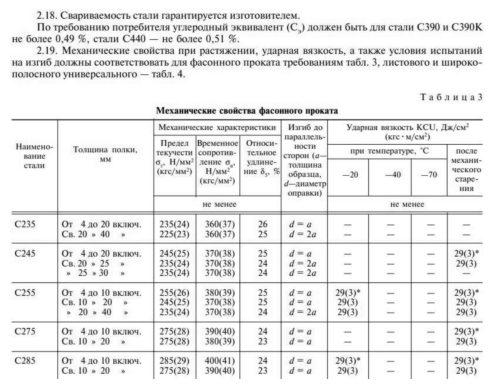

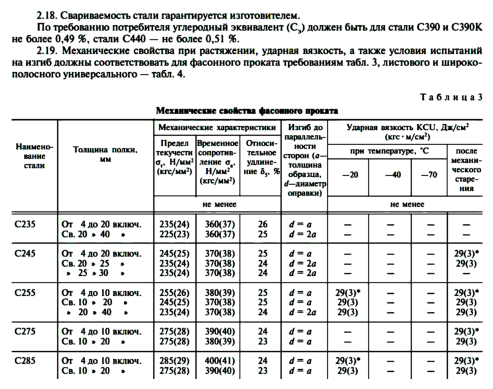

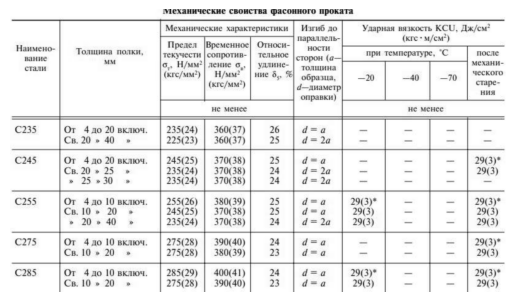

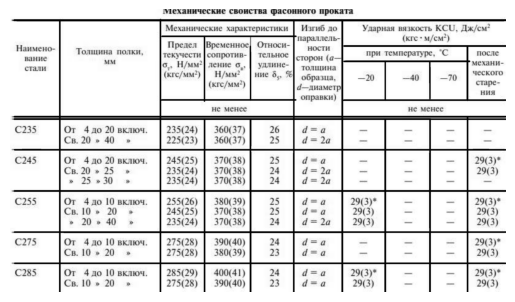

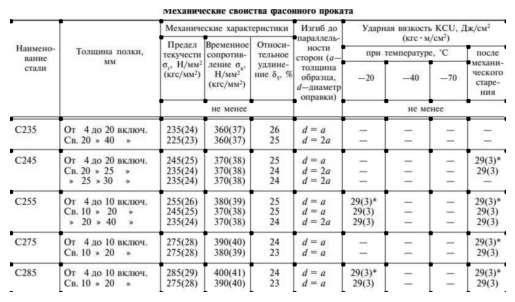

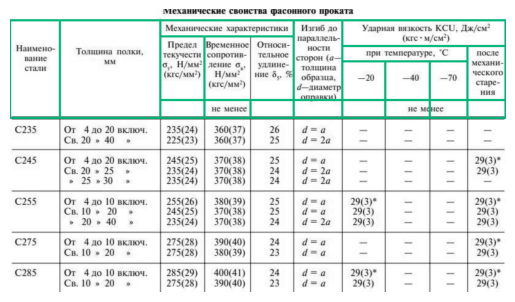

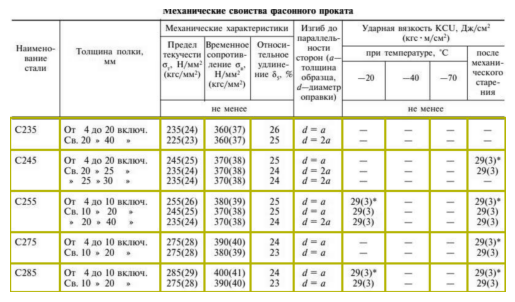

In [154]:
extractor = TableExtraction()
extractor.extract_from_file('6_part.pdf')